In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Functions import JSA, FtS, FtS2
from FunctionsCW import Total_propCW
from scipy.linalg import expm

In [2]:
#Parameters
Np = 0.04 # 0.000002 for low gain which agrees well ish
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)


#For numerical FT
nk=401
k_ft = 200/l
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)

In [7]:
#Defining pump envelope and dispersion relations
ws = vs*k
wi = vi*k
t=np.arange(0,100,0.5)


In [8]:
K = Total_propCW(k,t,ws,wi,Np,l)

In [9]:
J, Ns, Schmidt, M, Nums, Numi = JSA(K,dk)

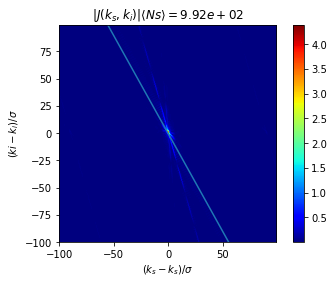

(4.391219392682128, 992.4309751537832, 1.4720406923890552)

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(J, cmap="jet", origin="lower", extent=[k[0],k[nk-1],k[0],k[nk-1]])
ax.plot(-(vs/vi)*k,k)
ax.set_xlabel(r"$(k_{s}-k_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-k_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()

np.amax(J),Ns,Schmidt

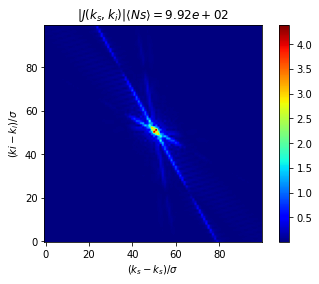

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(J[150:250,150:250], cmap="jet", origin="lower")
ax.set_xlabel(r"$(k_{s}-k_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-k_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()

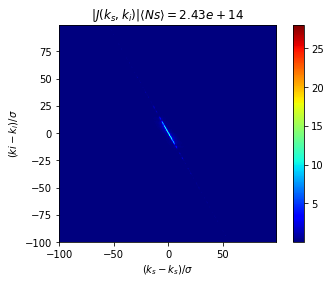

(28.059929142196598, 242624462422249.1, 2.794330941023771)

In [10]:
Rs = np.diag(-1j*ws)
Ri = np.diag(1j*wi)
S = 1j*(np.sqrt(Np)*l*dk/(2*np.pi))*np.sinc(l*(k+k[:,np.newaxis])/(2*np.pi)) #Extra factors of pi due to np.sinc definition
Q = np.block([[Rs,S],[np.conjugate(S),Ri]])

K = expm(Q*1000)

J, Ns, Schmidt, M, Nums, Numi = JSA(K,dk)

fig, ax = plt.subplots()
im = ax.imshow(J, cmap="jet", origin="lower", extent=[k[0],k[nk-1],k[0],k[nk-1]])
#ax.plot(-(vs/vi)*k,k)
ax.set_xlabel(r"$(k_{s}-k_{s})/\sigma$")
ax.set_ylabel(r"$(k{i}-k_{i})/\sigma$")
ax.set_title(r"$|J(k_{s}, k_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()

np.amax(J),Ns,Schmidt

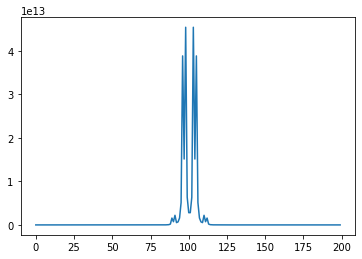

In [11]:
Es = np.abs(np.diag(Nums))

plt.plot(Es[100:300])

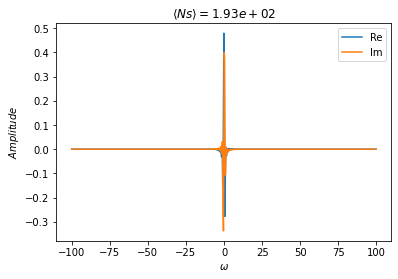

In [10]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val1, u1 = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(k, np.real(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u1[(nk-1)//2,-mark]))*u1[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

In [41]:
#Trying to remove free propagating phases which don't give anything "useful". OK so this is how to do it for single pass
T=K
N = len(T)
ks = -vs
ki = vi
l=t[-1]
Uss = (
    np.diag(np.exp(-1j * ks * k * l / 2))
    @ T[0 : N // 2, 0 : N // 2]
    @ np.diag(np.exp(-1j * ks * k * l / 2))
)
Usi = (
     np.diag(np.exp(-1j * ks * k * l / 2))
    @ T[0 : N // 2, N // 2 : N]
    @ np.diag(np.exp(1j * ki * k * l / 2))
    )
Uiss = (
        np.diag(np.exp(1j * ki * k * l / 2))
        @ T[N // 2 : N, 0 : N // 2]
        @ np.diag(np.exp(-1j * ks * k* l / 2))
    )
Uiis = (
        np.diag(np.exp(1j * ki * k * l / 2))
        @ T[N // 2 : N, N // 2 : N]
        @ np.diag(np.exp(1j * ki * k * l / 2))
    )
U = np.block([[Uss, Usi], [Uiss, Uiis]])

Nums2 = np.conj(Usi) @ Usi.T


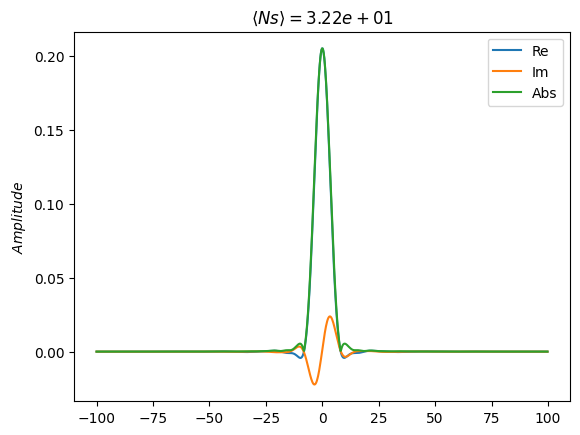

In [45]:
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val2, u2 = np.linalg.eigh(Nums2)

fig, ax1 = plt.subplots()
ax1.plot(k, np.real(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(k, np.imag(np.exp(-1j*np.angle(u2[(nk-1)//2,-mark]))*u2[:,-mark]), label='Im')
ax1.plot(k, np.abs(u2[:,-mark]), label='Abs')
#ax1.plot(x, np.imag(np.exp(-1j*np.angle(u1[(N-1)//2,-mark]))*u1[:,-mark]), label='Im')
#ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

In [16]:
S_t1=1j*(np.sqrt(Np)*l*dk/(2*np.pi))*np.sinc(l*(k+k[:,np.newaxis])/(2*np.pi))*np.exp(1j*(vs*k+vi*k[:,np.newaxis])*1)
S_t2=1j*(np.sqrt(Np)*l*dk/(2*np.pi))*np.sinc(l*(k+k[:,np.newaxis])/(2*np.pi))*np.exp(1j*(vs*k+vi*k[:,np.newaxis])*5)

Q1 = np.block([[0*np.eye(len(S_t1)),S_t1],[np.conjugate(S_t1),0*np.eye(len(S_t1))]])
Q2 = np.block([[0*np.eye(len(S_t1)),S_t2],[np.conjugate(S_t2),0*np.eye(len(S_t1))]])

In [17]:
np.allclose(Q1@Q2-Q2@Q1,np.zeros_like(Q1))

False

In [18]:
np.allclose(S_t1@S_t2-S_t2@S_t1,np.zeros_like(S_t1))

False

In [9]:
Comm = Q1@Q2-Q2@Q1